<a href="https://colab.research.google.com/github/Julesih/marked-beetle-analysis/blob/main/Copy_of_1000efficientnet_B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
filenames = os.listdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")
filenames[:4]

['PaperedControl20d.tif',
 'PaperedControl20d_light.tif',
 'PaperedControl21v.tif',
 'PaperedControl21v_light.tif']

In [6]:
train_images=[]
for filename in filenames:
    if filename.startswith('Papered') or filename.startswith('NoPapered'):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") #filename.startswith('Pink')

Number of Train images: 801


In [7]:
test_images=[]
for filename in filenames:
    if filename.startswith('Trap'):
        test_images.append(filename)
print(f"Number of Test images: {len(test_images)}")

Number of Test images: 77


In [8]:
categories = []
for filename in train_images:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('marked')
    if filename.startswith('NoPapered'):
        categories.append('unmarked')
len(categories)

801

In [9]:
df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df

,filename,category
0,PaperedControl20d.tif,marked
1,PaperedControl20d_light.tif,marked
2,PaperedControl21v.tif,marked
3,PaperedControl21v_light.tif,marked
4,PaperedControl21d.tif,marked
...,...,...
796,PaperedControl18d.tif,marked
797,PaperedControl19v.tif,marked
798,PaperedControl19d.tif,marked
799,PaperedControl20v.tif,marked


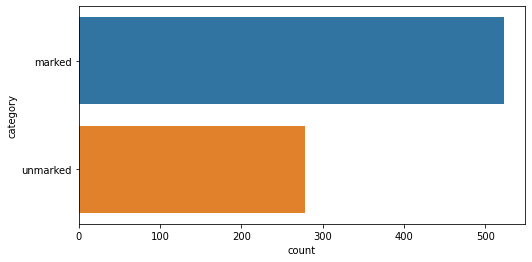

In [8]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=df);

In [10]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", filenames[0]))
image.shape

(1944, 2592, 3)

In [11]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [12]:
tmp_df = df.sample(9)
tmp_df

,filename,category
404,NoPaperedGreen22d.tif,unmarked
25,PaperedControl29v.tif,marked
355,PaperedTransparent100v.tif,marked
466,NoPaperedGreen56v.tif,unmarked
67,PaperedControl46d.tif,marked
580,NoPaperedMixed28v.tif,unmarked
75,PaperedControl50d.tif,marked
363,PaperedTransparent104v.tif,marked
464,NoPaperedGreen55d.tif,unmarked


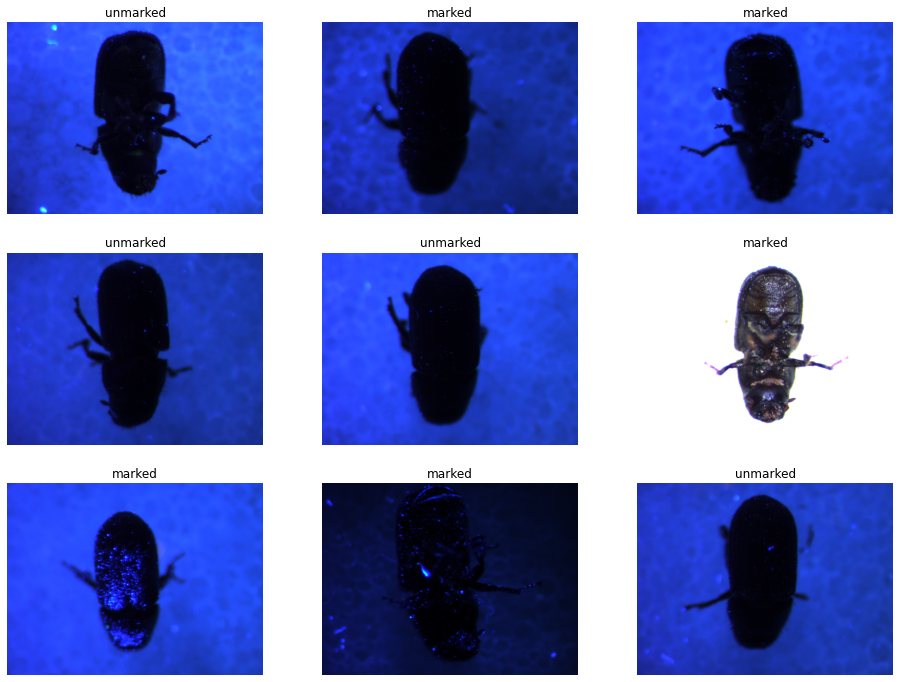

In [12]:
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [13]:
#df["category"] = df["category"].replace({0: 'NotMarked', 1: 'Marked'}) 

In [13]:
train_df, validate_df = train_test_split(df, test_size = 0.10, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

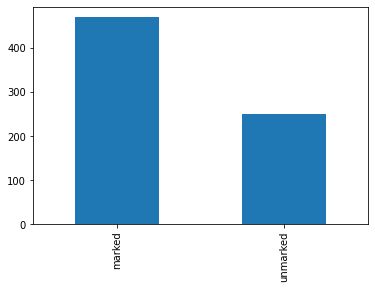

In [14]:
train_df['category'].value_counts().plot.bar()

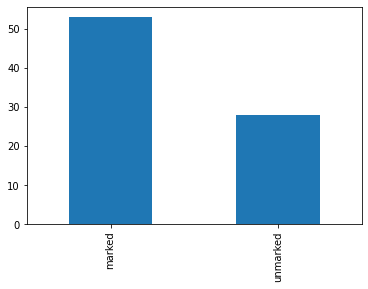

In [15]:
validate_df['category'].value_counts().plot.bar()

In [207]:
IMG_SIZE = 1000
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2
BATCH_SIZE = 15

In [217]:
def threshcrop(img):
  #convert to grayscale and apply adaptive thresholding
    grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(grayscale,(5,5),0).astype('uint8')
    retval,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    return thresh

    #detect edges and crop the image
    #canny = cv2.Canny(thresh, 50, 200)
    #pts = np.argwhere(canny > 0)
    #y1,x1 = pts.min(axis=0)
    #y2,x2 = pts.max(axis=0)
    #cropped_img = thresh[y1:y2, x1:x2]

    #return cropped_img


In [218]:
datagen_train = ImageDataGenerator(preprocessing_function=threshcrop)

In [219]:
datagen_val = ImageDataGenerator(preprocessing_function=threshcrop)

In [220]:
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="grayscale",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 720 validated image filenames belonging to 2 classes.


In [221]:
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="grayscale",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 81 validated image filenames belonging to 2 classes.


In [222]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import  Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import layers

def create_model():
    inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
    model = EfficientNetB7(include_top=False, input_tensor=inputs, weights="imagenet")
    #model = EfficientNetB7(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                            # weights = 'imagenet',
                             #drop_connect_rate=0.6)
    # Freeze the pretrained weights
    model.trainable = False


    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    #x = layers.Flatten()(x)

    x = layers.Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001))(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    return model

model = create_model()
#model.summary()

In [223]:
EPOCHS = 50
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [224]:
def Model_fit():
    
    #leaf_model = None
    
    model = create_model()
    
    '''Compiling the model'''
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("best_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('model'+'.h5')  
    return history

In [225]:
results = Model_fit()

ValueError: ignored

In [197]:
print('Train_Cat-Acc: ', max(results.history['accuracy']))
print('Val_Cat-Acc: ', max(results.history['val_accuracy']))

NameError: ignored

In [ ]:
print('Train_Cat-Loss: ', min(results.history['loss']))
print('Val_Cat-Loss: ', min(results.history['val_loss']))

Train_Cat-Loss:  0.25871580839157104
Val_Cat-Loss:  0.252409428358078


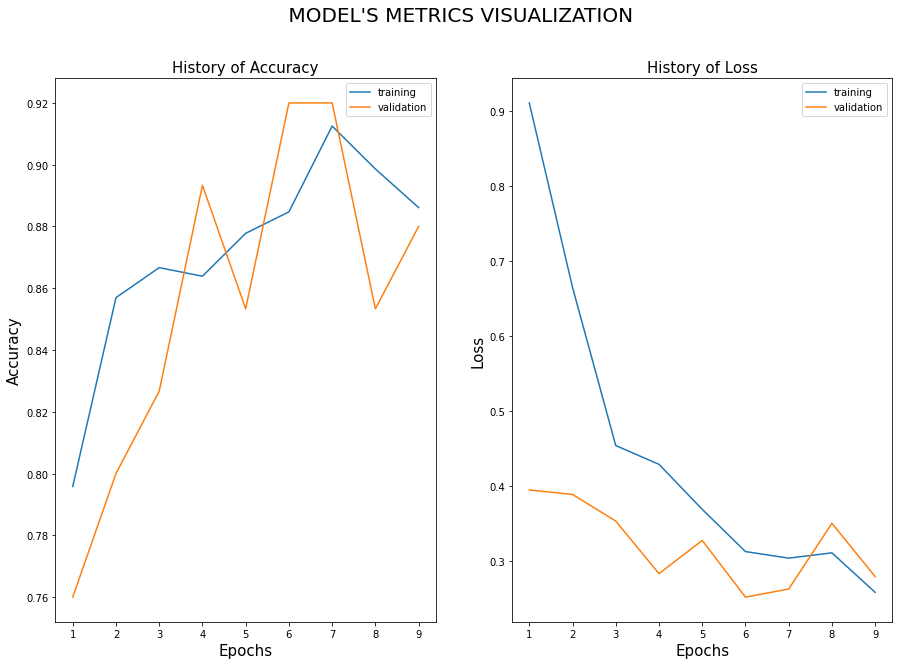

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['accuracy'],results.history['val_accuracy'],
               results.history['loss'],results.history['val_loss'])

In [ ]:
import keras

final_model = keras.models.load_model('1000best_model.h5')

In [ ]:
tmp_df1=df.sample(10)
tmp_df1

,filename,category
794,PaperedControl17d.tif,marked
514,NoPaperedGreen80v.tif,unmarked
244,PaperedTransparent47v.tif,marked
798,PaperedControl19d.tif,marked
774,NoPaperedGreen9d.tif,unmarked
485,NoPaperedGreen65d.tif,unmarked
739,PaperedControl2v.tif,marked
461,NoPaperedGreen53d.tif,unmarked
447,NoPaperedGreen46d.tif,unmarked
203,PaperedTransparent27v.tif,marked


In [ ]:
preds=[]
for image_id in tmp_df1.filename:
  image = Image.open(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis/",image_id))
  image = image.resize(size)
  image = np.expand_dims(image,axis=0)
  preds.append(np.argmax(final_model.predict(image)))
tmp_df1["prediction"]=preds

In [ ]:
tmp_df1["prediction"] = tmp_df1["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1

,filename,category,prediction
794,PaperedControl17d.tif,marked,marked
514,NoPaperedGreen80v.tif,unmarked,marked
244,PaperedTransparent47v.tif,marked,marked
798,PaperedControl19d.tif,marked,marked
774,NoPaperedGreen9d.tif,unmarked,marked
485,NoPaperedGreen65d.tif,unmarked,marked
739,PaperedControl2v.tif,marked,marked
461,NoPaperedGreen53d.tif,unmarked,unmarked
447,NoPaperedGreen46d.tif,unmarked,marked
203,PaperedTransparent27v.tif,marked,marked
